In [1]:
import numpy as np

# Create monkey patches
np.float = float
np.int = int
np.object = object
np.bool = bool

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from PopMusicInformationRetrieval import gunshot_utils as utils
import importlib
import torch as th
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import librosa
import soundfile as sf
from pydub.playback import play
import os
import numpy as np
import torchaudio

importlib.reload(utils)

<module 'PopMusicInformationRetrieval.gunshot_utils' from '/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/gunshot_utils.py'>

In [3]:
gunshot_df = pd.read_pickle('pkl_data/gunshot_data_glock_only.pkl')
gunshot_df = gunshot_df[['filename', 'gunshot_location_in_seconds', 'num_gunshots']]
gunshot_df

,filename,gunshot_location_in_seconds,num_gunshots
0,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.72269841],1
41,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.75],1
42,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.75],1
43,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.75],1
44,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"[1.75, 3.63755102, 5.55709751]",3
...,...,...,...
1552,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.75],1
1572,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[7.49117914],1
1573,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.75],1
1607,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"[0.04662132, 0.31596372, 1.33662132, 1.6201133...",6


In [4]:
def process_gunshot_data(file_path):
    # Extract the base filename and replace .txt with .wav
    base_name = os.path.basename(file_path)
    wav_filename = os.path.splitext(base_name)[0] + '.wav'
    start_times = []
    with open(file_path, 'r') as file:
        for line in file:
            columns = line.split()
            if len(columns) >= 1:
                start_time = float(columns[0])
                start_times.append(start_time)
    # Get the length of the list
    list_length = len(start_times)
    # Construct the full path for the wav file
    full_wav_path = os.path.join(os.path.dirname(file_path), wav_filename)
    return full_wav_path, start_times, list_length

def build_dataframe_from_folder(folder_path):
    data = {
        'filename': [],
        'gunshot_location_in_seconds': [],
        'num_gunshots': []
    }

    # Iterate through the folder and find all .txt files
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            wav_filename, start_times, list_length = process_gunshot_data(file_path)

            # Append data to the dataframe columns
            data['filename'].append(wav_filename)
            data['gunshot_location_in_seconds'].append(start_times)
            data['num_gunshots'].append(list_length)

    # Create the DataFrame
    df = pd.DataFrame(data, columns=['filename', 'gunshot_location_in_seconds', 'num_gunshots'])
    return df

folder_path = './Data/gunshot'
gunshot_valid_df = build_dataframe_from_folder(folder_path)

In [5]:
music_df = pd.read_pickle('pkl_data/dataset_with_onset.pkl')
music_df.head()

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,...,Delta2_MFCC_Mean_18,Delta2_MFCC_Std_18,Raw_MFCC_Mean_19,Raw_MFCC_Std_19,Delta_MFCC_Mean_19,Delta_MFCC_Std_19,Delta2_MFCC_Mean_19,Delta2_MFCC_Std_19,onsets,num_onsets
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,-0.000043,0.915235,-3.153454,7.475548,0.000035,1.343144,0.000203,0.937476,"[0.14933333333333335, 0.384, 1.130666666666666...",1650
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,-0.000426,1.016737,-0.245936,8.659272,0.000176,1.617870,-0.000542,1.091836,"[0.128, 2.2826666666666666, 2.421333333333333,...",1811
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.000095,0.773686,-0.547386,7.437192,-0.000105,1.368790,0.000157,0.859366,"[0.13866666666666666, 0.7893333333333333, 1.10...",1261
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.000087,0.769571,-1.566297,6.675558,-0.000312,1.268046,0.000172,0.856217,"[0.14933333333333335, 4.074666666666666, 4.917...",1006
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,-0.000235,0.895271,-2.257458,8.397979,-0.000024,1.502904,-0.000187,0.987014,"[0.13866666666666666, 0.23466666666666666, 0.5...",867


In [20]:
import os

# Update the 'Path' column to reflect the new output folder
output_folder = '/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/Data/music2'

# Define a function to update each path to point to the new location in the output folder
def update_path(path, old_folder, new_folder):
    # Extract the base name of the file (e.g., 'song.mp3')
    base_name = os.path.basename(path)
    # Join the new output folder with the base name
    new_path = os.path.join(new_folder, base_name)
    return new_path

# Update the 'Path' column in df_result
music_df['Path'] = music_df['Path'].apply(lambda x: update_path(x, old_folder='', new_folder=output_folder))

# Now df_result['Path'] has updated paths pointing to the new output folder
print(music_df.head())


  Artist                                Album                       Song  \
0  Big L  Lifestylez Ov Da Poor and Dangerous             8 Iz Enuff.mp3   
1  Big L  Lifestylez Ov Da Poor and Dangerous           Da Graveyard.mp3   
2  Big L  Lifestylez Ov Da Poor and Dangerous  I Don't Understand It.mp3   
3  Big L  Lifestylez Ov Da Poor and Dangerous      No Endz, No Skinz.mp3   
4  Big L  Lifestylez Ov Da Poor and Dangerous                    MVP.mp3   

        Coast  Release Year      Tempo1     Tempo2  Duration (s)  \
0  east_coast          1995   96.774194  48.000000    298.840000   
1  east_coast          1995   93.750000  46.511628    323.760000   
2  east_coast          1995   93.750000  47.244094    260.226667   
3  east_coast          1995  100.000000  50.420168    208.733333   
4  east_coast          1995   86.956522  43.478261    218.866667   

   Sample Rate (Hz)                                               Path  ...  \
0             48000  /Users/borosabel/Documents/Uni/The

In [21]:
music_df

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,...,Delta2_MFCC_Mean_18,Delta2_MFCC_Std_18,Raw_MFCC_Mean_19,Raw_MFCC_Std_19,Delta_MFCC_Mean_19,Delta_MFCC_Std_19,Delta2_MFCC_Mean_19,Delta2_MFCC_Std_19,onsets,num_onsets
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMusic...,...,-0.000043,0.915235,-3.153454,7.475548,0.000035,1.343144,0.000203,0.937476,"[0.14933333333333335, 0.384, 1.130666666666666...",1650
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMusic...,...,-0.000426,1.016737,-0.245936,8.659272,0.000176,1.617870,-0.000542,1.091836,"[0.128, 2.2826666666666666, 2.421333333333333,...",1811
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMusic...,...,0.000095,0.773686,-0.547386,7.437192,-0.000105,1.368790,0.000157,0.859366,"[0.13866666666666666, 0.7893333333333333, 1.10...",1261
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMusic...,...,0.000087,0.769571,-1.566297,6.675558,-0.000312,1.268046,0.000172,0.856217,"[0.14933333333333335, 4.074666666666666, 4.917...",1006
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMusic...,...,-0.000235,0.895271,-2.257458,8.397979,-0.000024,1.502904,-0.000187,0.987014,"[0.13866666666666666, 0.23466666666666666, 0.5...",867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,Dr.Dre,The Chronic,Dr. Dre - The Day the Niggaz Took Over (feat. ...,west_coast,1992,93.750000,46.875000,273.206000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMusic...,...,0.000014,0.965833,3.105422,8.107130,0.000300,1.398945,-0.000331,0.943893,"[0.07466666666666667, 0.16, 1.7813333333333334...",1327
1360,Dr.Dre,The Chronic,"Dr. Dre - Bitches Ain't Shit (feat. Jewell, Sn...",west_coast,1992,92.307692,46.153846,287.207625,48000,/Users/borosabel/Documents/Uni/Thesis/PopMusic...,...,-0.000104,0.923382,3.585479,8.419474,-0.000094,1.344639,-0.000100,0.945971,"[0.256, 0.416, 0.448, 0.6186666666666667, 0.94...",1322
1361,Dr.Dre,The Chronic,Dr. Dre - Stranded On Death Row (feat. Bushwic...,west_coast,1992,90.909091,45.801527,287.335333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMusic...,...,-0.000096,0.872956,-1.408088,7.179779,-0.000186,1.220260,-0.000089,0.895696,"[0.30933333333333335, 0.384, 1.792, 1.89866666...",1779
1362,Dr.Dre,The Chronic,Dr. Dre - Nuthin' but a ＂G＂ Thang (feat. Snoop...,west_coast,1992,95.238095,47.244094,238.677917,48000,/Users/borosabel/Documents/Uni/Thesis/PopMusic...,...,0.000286,0.962360,3.666350,8.740702,-0.000545,1.380348,0.000392,0.903614,"[0.07466666666666667, 0.224, 0.874666666666666...",999


<b>Above we just loaded the gunshot data and the music data with the onsets</b>

In [22]:
print(gunshot_df.shape) # Gunshots for artificial gunshot+music generation
print(gunshot_valid_df.shape) # Real gunshots in real music
print(music_df.shape) # Normal music files with onsets

(193, 3)
(19, 3)
(1364, 392)


In [23]:
music_train_df, music_valid_df = train_test_split(music_df, test_size=0.2, random_state=42)

# We don't take the gunshot_valid here because we have our own validation set.
gunshot_train_df, _ = train_test_split(gunshot_df, test_size=0.2, random_state=42) 

In [24]:
print("SHAPES:")
print(f"music_train_df: {music_train_df.shape}, music_valid_df: {music_valid_df.shape}")
print(f"gunshot_train_df: {gunshot_train_df.shape}, gunshot_valid_df: {gunshot_valid_df.shape}")

SHAPES:
music_train_df: (1091, 392), music_valid_df: (273, 392)
gunshot_train_df: (154, 3), gunshot_valid_df: (19, 3)


In [25]:
class GunshotDetectionCNN(nn.Module):
    def __init__(self, num_frames):
        super(GunshotDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=(3, 7))
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 1))
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 1))

        dummy_input = th.zeros(1, 3, 80, num_frames)
        dummy_output = self.pool2(F.relu(self.conv2(self.pool1(F.relu(self.conv1(dummy_input))))))
        output_size = dummy_output.view(-1).shape[0]

        self.fc1 = nn.Linear(output_size, 256)
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)

        x = self.dropout(F.relu(self.fc1(x))) 
        x = self.sigmoid(self.fc2(x))
        return x

# class GunshotDetectionCNN(nn.Module):
#     def __init__(self, num_frames, n_mels):
#         super(GunshotDetectionCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 10, kernel_size=(3, 7))
#         self.pool1 = nn.MaxPool2d(kernel_size=(3, 1))
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3))
#         self.pool2 = nn.MaxPool2d(kernel_size=(3, 1))
#         self.dropout = nn.Dropout(0.5)
#         self.sigmoid = nn.Sigmoid()
# 
#         # Update dummy_input with new dimensions
#         dummy_input = th.zeros(1, 3, n_mels, num_frames)
#         dummy_output = self.pool2(F.relu(self.conv2(self.pool1(F.relu(self.conv1(dummy_input))))))
#         output_size = dummy_output.view(-1).shape[0]
# 
#         self.fc1 = nn.Linear(output_size, 256)
#         self.fc2 = nn.Linear(256, 1)
# 
#     def forward(self, x):
#         x = self.pool1(F.relu(self.conv1(x)))
#         x = self.pool2(F.relu(self.conv2(x)))
#         x = x.view(x.size(0), -1)
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.sigmoid(self.fc2(x))
#         return x
    
model = GunshotDetectionCNN(num_frames=utils.NUM_FRAMES)
# model = GunshotDetectionCNN(num_frames=utils.NUM_FRAMES, n_mels=utils.N_MELS)

In [26]:
class GunshotDataset(th.utils.data.Dataset):
    def __init__(self, music_df, gunshot_df, music_metadata, gunshot_prob=0.5, num_samples=1000, real_music_gunshot=False, shuffle=True):
        super().__init__()
        self.music_paths = music_df['Path'].tolist()
        self.music_onsets = music_df['onsets'].tolist()
        self.gunshot_paths = gunshot_df['filename'].tolist()
        self.gunshot_truth = gunshot_df['gunshot_location_in_seconds'].tolist()
        self.music_metadata = music_metadata
        self.gunshot_prob = gunshot_prob
        self.num_samples = num_samples
        self.real_music_gunshot = real_music_gunshot
        self.shuffle = shuffle

    def __getitem__(self, idx):
        if not self.shuffle:
            # Use idx directly when shuffle=False
            music_idx = idx % len(self.music_paths)
            gunshot_idx = idx % len(self.gunshot_paths)
        else:
            # Randomly pick indices when shuffle=True
            music_idx = np.random.randint(0, len(self.music_paths))
            gunshot_idx = np.random.randint(0, len(self.gunshot_paths))

        fn_music = self.music_paths[music_idx]
        onset_times = self.music_onsets[music_idx]
        fn_music_metadata = self.music_metadata[fn_music]

        add_gunshot = (np.random.rand() < self.gunshot_prob) if self.shuffle else (idx % 2 == 0)

        if add_gunshot:
            spectrograms, labels, waveform_segment = self._add_gunshot(fn_music, fn_music_metadata, onset_times, gunshot_idx, idx)
        else:
            spectrograms, labels, waveform_segment  = self._add_music_only(fn_music, fn_music_metadata, onset_times)

        if not spectrograms or not labels:
            raise ValueError("Spectrograms or labels are empty after preprocessing")

        return spectrograms[0], labels[0], waveform_segment

    def _get_spectrograms_and_labels(self):
        """Helper function to retrieve spectrograms and labels."""
        add_gunshot = (np.random.rand() < self.gunshot_prob)
        music_idx = np.random.randint(0, len(self.music_paths))
        fn_music = self.music_paths[music_idx]  
        onset_times = self.music_onsets[music_idx]
        fn_music_metadata = self.music_metadata[fn_music]

        if add_gunshot:
            spectrograms, labels = self._add_gunshot(fn_music, fn_music_metadata, onset_times)
        else:
            spectrograms, labels = self._add_music_only(fn_music, fn_music_metadata, onset_times)
        return spectrograms, labels

    def _add_gunshot(self, fn_music, fn_music_metadata, onset_times, gunshot_idx, idx):
        """Handles adding gunshot to music or using a standalone gunshot segment."""
        spectrograms, labels = [], []
        fn_gunshot = self.gunshot_paths[gunshot_idx]
        gunshot_times = self.gunshot_truth[gunshot_idx]
    
        if self.real_music_gunshot:
            if gunshot_times:
                spectrograms, labels, gunshot_segment = self._process_gunshot_only(fn_gunshot, gunshot_times, idx)
        else:
            spectrograms, labels, gunshot_segment = self._combine_music_and_gunshot(fn_music, fn_music_metadata, fn_gunshot, gunshot_times, onset_times, idx)
        return spectrograms, labels, gunshot_segment

    def _process_gunshot_only(self, fn_gunshot, gunshot_times, idx):
        """Processes a standalone gunshot segment."""
        if not self.shuffle:
            gunshot_time = gunshot_times[idx % len(gunshot_times)]
        else:
            gunshot_time = gunshot_times[np.random.randint(0, len(gunshot_times))]
    
        gunshot_waveform, sr_gunshot = torchaudio.load(fn_gunshot)
        gunshot_segment = utils.select_gunshot_segment(gunshot_waveform, sr_gunshot, gunshot_time)
        spectrograms, labels = utils.preprocess_audio_train(gunshot_segment, label=1)
        return spectrograms, labels, gunshot_segment


    def _combine_music_and_gunshot(self, fn_music, fn_music_metadata, fn_gunshot, gunshot_times, onset_times, idx):
        """Combines music and gunshot into one segment and processes it."""
        spectrograms, labels = [], []
        music_waveform = utils.select_valid_onset_segment(file_path=fn_music, metadata=fn_music_metadata, onset_times=onset_times)
    
        if gunshot_times:
            if not self.shuffle: 
                gunshot_time = gunshot_times[idx % len(gunshot_times)]
            else:
                gunshot_time = gunshot_times[np.random.randint(0, len(gunshot_times))]
    
            segment, sr = utils.combine_music_and_gunshot(music_waveform, fn_gunshot, gunshot_time, gunshot_volume_increase_dB=0)
            spectrograms, labels = utils.preprocess_audio_train(segment, label=1)
    
        return spectrograms, labels, segment


    def _add_music_only(self, fn_music, fn_music_metadata, onset_times):
        """Processes a music segment without a gunshot."""
        music_waveform = utils.select_valid_onset_segment(file_path=fn_music, metadata=fn_music_metadata, onset_times=onset_times)
        spectrograms, labels = utils.preprocess_audio_train(music_waveform, label=0)
        return spectrograms, labels, music_waveform

    def get_random_music_with_gunshot(self, idx=None):
        """
        Returns a random waveform that contains both music and gunshot.
        """
        spectrograms = []
        segment = None
    
        if self.real_music_gunshot:
            gunshot_idx = np.random.randint(0, len(self.gunshot_paths)) if self.shuffle else idx % len(self.gunshot_paths)
            fn_gunshot = self.gunshot_paths[gunshot_idx]
            gunshot_times = self.gunshot_truth[gunshot_idx]
    
            if gunshot_times:
                spectrograms, _, segment = self._process_gunshot_only(fn_gunshot, gunshot_times, idx)
        else:
            music_idx = np.random.randint(0, len(self.music_paths)) if self.shuffle else idx % len(self.music_paths)
            fn_music = self.music_paths[music_idx]
            onset_times = self.music_onsets[music_idx]
            fn_music_metadata = self.music_metadata[fn_music]
            music_waveform = utils.select_valid_onset_segment(file_path=fn_music, metadata=fn_music_metadata, onset_times=onset_times)
    
            gunshot_idx = np.random.randint(0, len(self.gunshot_paths)) if self.shuffle else idx % len(self.gunshot_paths)
            fn_gunshot = self.gunshot_paths[gunshot_idx]
            gunshot_times = self.gunshot_truth[gunshot_idx]
    
            # Pick a single time from gunshot_times
            if gunshot_times:
                gunshot_time = gunshot_times[idx % len(gunshot_times)] if not self.shuffle else gunshot_times[np.random.randint(0, len(gunshot_times))]
                segment, _ = utils.combine_music_and_gunshot(music_waveform, fn_gunshot, gunshot_time)
                spectrograms, _ = utils.preprocess_audio_train(segment, label=1)
    
        return segment, spectrograms[0] if spectrograms else None

    def get_random_music_onset(self):
        """Returns a random music onset segment."""
        music_idx = np.random.randint(0, len(self.music_paths))
        fn_music = self.music_paths[music_idx]
        onset_times = self.music_onsets[music_idx]
        fn_music_metadata = self.music_metadata[fn_music]
        music_waveform = utils.select_valid_onset_segment(file_path=fn_music, metadata=fn_music_metadata, onset_times=onset_times)
        music_spectrograms, _ = utils.preprocess_audio_train(music_waveform, label=0)
        return music_waveform, music_spectrograms[0] if music_spectrograms else None
    
    def __len__(self):
        return self.num_samples 

In [46]:
def generate_audio_metadata(folder_path):
    """
    Generates metadata for all audio files in a specified folder.

    Parameters:
    - folder_path: str, path to the folder containing audio files.

    Returns:
    - metadata_dict: dict, a dictionary with file paths as keys and metadata as values.
    """
    # Initialize an empty dictionary to store the metadata
    metadata_dict = {}

    # Iterate through all files in the folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Construct full path to the file
            file_path = os.path.join(root, file)

            try:
                # Load audio file with librosa to obtain sample rate and duration
                y, sr = librosa.load(file_path, sr=None, mono=False)

                # Read audio metadata with soundfile (e.g., number of channels)
                with sf.SoundFile(file_path) as sound_file:
                    channels = sound_file.channels
                    num_frames = len(y[0]) if channels > 1 else len(y)
                    duration = sound_file.frames / sound_file.samplerate

                # Store metadata in dictionary
                metadata_dict[file_path] = {
                    'sample_rate': sr,
                    'channels': channels,
                    'duration': duration,
                    'num_frames': num_frames,
                }

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    return metadata_dict

# Usage example
folder_path = '/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/Data/music2'
audio_metadata = generate_audio_metadata(folder_path)

In [33]:
# music_metadata = utils.create_metadata_map('./Data/music')

In [48]:
music_metadata = audio_metadata

In [49]:
train_dataset = GunshotDataset(music_train_df, gunshot_train_df, music_metadata, gunshot_prob=0.5, num_samples=5000, shuffle=True)
valid_dataset = GunshotDataset(music_valid_df, gunshot_valid_df, music_metadata, gunshot_prob=0.5, num_samples=500, real_music_gunshot=True, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

<b>Spectograms for onset data</b>

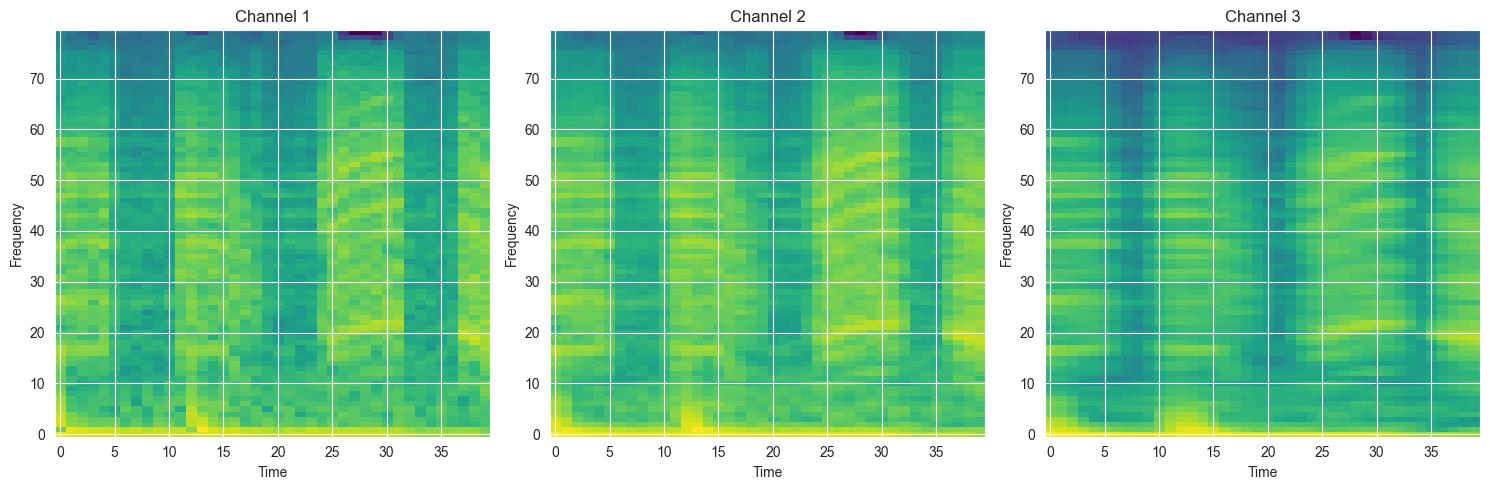

In [50]:
waveform, spectrogram = train_dataset.get_random_music_onset()
# plot_spectrogram_rgb(spectrogram)
utils.play_audio(waveform)
utils.plot_spectrogram_channels(spectrogram)

<b>Spectograms for gunshot data</b>

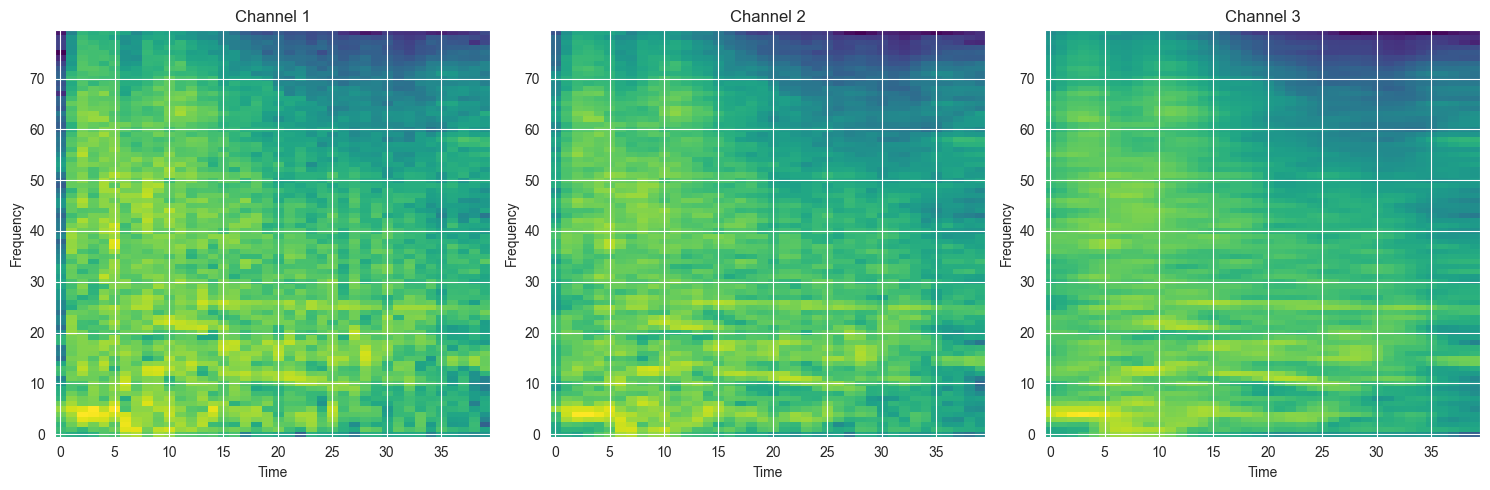

In [51]:
waveform, spectrogram = valid_dataset.get_random_music_with_gunshot(idx=14) 
# plot_spectrogram_rgb(spectrogram)
utils.play_audio(waveform)
utils.plot_spectrogram_channels(spectrogram)

In [52]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
use_cuda = th.cuda.is_available()

mean, std = utils.compute_mean_std(train_loader)
mean = mean.to(device)
std = std.to(device)

Computing mean and std: 100%|██████████| 157/157 [00:37<00:00,  4.24it/s]


In [53]:
importlib.reload(utils)

<module 'PopMusicInformationRetrieval.gunshot_utils' from '/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/gunshot_utils.py'>

In [55]:
epochs = 50

optimizer = th.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = th.nn.BCELoss()

best_threshold, best_score, last_failed_samples = utils.train_model(
    model, optimizer, criterion, train_loader, valid_loader, num_epochs=epochs, mean=mean, std=std, patience=15
)
print('best threshold', best_threshold)

/Users/borosabel/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [1] Training: 100%|██████████| 157/157 [00:42<00:00,  3.73it/s, loss=0.681]


Epoch [1], Loss: 0.6519


RuntimeError: stack expects each tensor to be equal size, but got [2, 19968] at entry 0 and [1, 19968] at entry 1

Threshold: 0.5
Model Prediction: No Gunshot with output: 0.4201057553291321
Label: 0.0, Prediction: 1.0, Prediction Model: No Gunshot


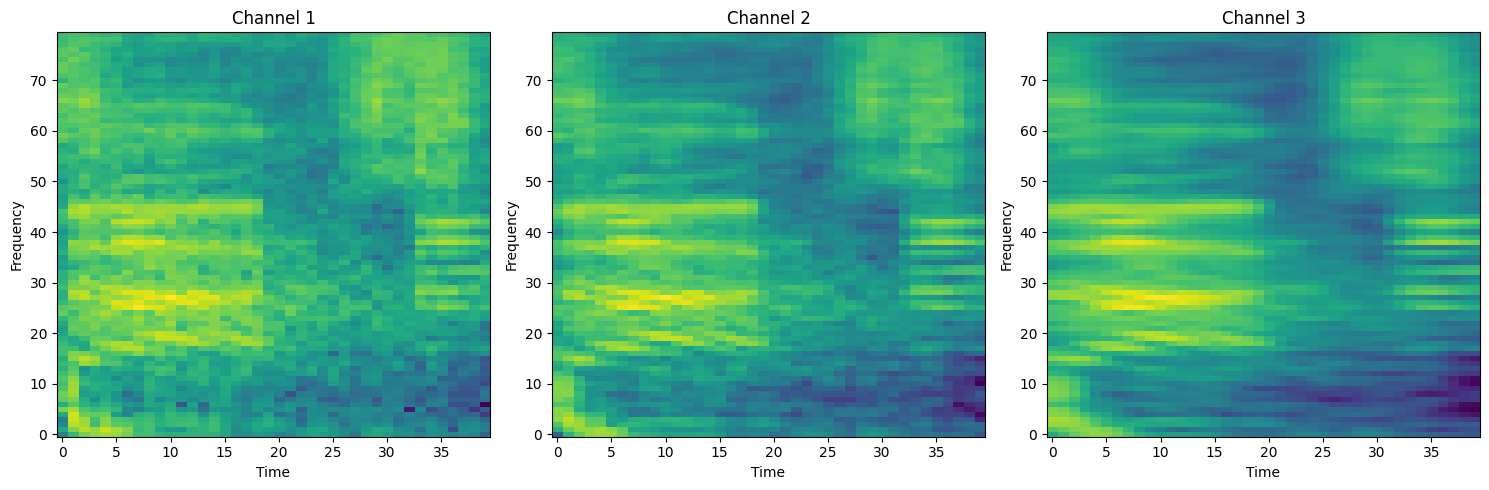

In [236]:
index = 1
label = last_failed_samples[index]['label']
prediction = last_failed_samples[index]['prediction']
waveform = last_failed_samples[index]['waveform']
spectogram = last_failed_samples[index]['spectrogram']
prediction_model = utils.process_spectrogram_and_predict(
    model=model,
    spectrogram=spectogram,
    mean=mean,
    std=std,
    threshold=best_threshold
)
print(f'Label: {label}, Prediction: {prediction}, Prediction Model: {prediction_model}')
utils.play_audio(waveform)
utils.plot_spectrogram_channels(spectogram)

In [37]:
def manual_evaluate_test(model, feature, threshold, frame_size=utils.NUM_FRAMES, sampling_rate=utils.SAMPLING_RATE, hop_length=utils.HOP_LENGTH, mean=None, std=None, step_size=None, filter_time_sec=0):
    """
    Manually evaluate the model on an audio feature, returning time positions where gunshots are detected.

    Parameters:
        model: The trained model.
        feature: The feature (e.g., spectrogram) to evaluate.
        threshold: The prediction threshold for gunshots.
        frame_size: Number of frames to use in each evaluation.
        sampling_rate: Audio sampling rate.
        hop_length: Hop length in samples for each frame.
        mean: Mean for normalization.
        std: Standard deviation for normalization.
        step_size: Step size for moving through frames (default: frame_size // 2).
        filter_time_sec: Time (in seconds) to filter out close consecutive predictions.
    
    Returns:
        List of tuples (minutes, seconds, output) where gunshots are detected along with the model's output.
    """
    if mean is None or std is None:
        raise ValueError("Mean and std must be provided for normalization.")

    mean = mean.to(device)
    std = std.to(device)
    model = model.to(device)
    model.eval()

    predictions = []

    feature = feature.to(device)
    feature = (feature - mean) / std

    num_frames = feature.shape[2]

    if step_size is None:
        step_size = 1

    total_iterations = 0

    with th.no_grad():
        for j in range(0, num_frames - frame_size + 1, step_size):
            total_iterations += 1
            start = j
            end = j + frame_size

            input_frame = feature[:, :, start:end].unsqueeze(0).float()
            output = model(input_frame).squeeze().item()
            predictions.append((output, start))

        print("Number of predictions", len(predictions))

        res = []
        for output, start in predictions:
            if output >= threshold:
                time_in_seconds = start * hop_length / sampling_rate
                minutes = int(time_in_seconds // 60)
                seconds = time_in_seconds % 60
                res.append((minutes, seconds, time_in_seconds, output))

    print(len(res))

    filtered_res = []
    last_detection_time = -float('inf')

    for minutes, seconds, time_in_seconds, output in res:
        if time_in_seconds - last_detection_time >= filter_time_sec:
            filtered_res.append((minutes, seconds, output))
            last_detection_time = time_in_seconds

    return filtered_res

In [108]:
# audio_path = './50 Cent - Many Men (Wish Death) (Dirty Version).mp3'
# spectrograms, sample_rates = utils.preprocess_audio(['/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/test_data_wav/Big L - Lifestylez Ov Da Poor And Dangerous.wav'])
spectrograms, sample_rates = utils.preprocess_audio(['/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/50 Cent - Many Men (Wish Death) (Dirty Version).mp3'])
# print(f"Got back spectogram in shape: {spectrograms[0].shape} and sample rate: {sample_rates}")

100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


In [116]:
predictions = manual_evaluate_test(model, spectrograms[0], threshold=0.8, mean=mean, std=std, step_size=1, filter_time_sec=1)

if(len(predictions) > 0):
    print(f"Current treshold is {best_threshold} \n")

    for minutes, seconds, output in predictions:
        print(f"Detected gunshot at {minutes}m {seconds:.2f}s with model output: {output:.4f}")
else:
    print("No predictions")

Number of predictions 25532
867
Current treshold is 0.5136889815330505 

Detected gunshot at 0m 2.75s with model output: 0.8081
Detected gunshot at 0m 5.60s with model output: 0.8173
Detected gunshot at 0m 8.38s with model output: 0.8034
Detected gunshot at 0m 11.23s with model output: 0.8109
Detected gunshot at 0m 12.24s with model output: 0.8148
Detected gunshot at 0m 13.25s with model output: 0.9204
Detected gunshot at 0m 23.34s with model output: 0.8039
Detected gunshot at 0m 38.51s with model output: 0.8027
Detected gunshot at 0m 43.17s with model output: 0.8058
Detected gunshot at 0m 45.27s with model output: 0.8048
Detected gunshot at 0m 46.99s with model output: 0.8027
Detected gunshot at 0m 48.16s with model output: 0.8037
Detected gunshot at 0m 49.17s with model output: 0.8248
Detected gunshot at 0m 50.18s with model output: 0.9579
Detected gunshot at 0m 54.30s with model output: 0.8014
Detected gunshot at 1m 13.96s with model output: 0.8037
Detected gunshot at 1m 15.48s with

In [118]:
audio_path = './50 Cent - Many Men (Wish Death) (Dirty Version).mp3'
prediction = utils.process_and_predict(model, audio_path, start_time_sec=73.96, mean=mean, std=std, threshold=0.8)

Treshold 0.8
Playing the audio sample from 73.96 seconds.


Input #0, wav, from '/var/folders/99/617f3z715_g8nc26tll89ddc0000gn/T/tmpnlopah2n.wav':
  Duration: 00:00:00.99, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s



Model Prediction: Gunshot with output: 0.8050265312194824
